In [1]:
# Helpers
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from tokenizer import create_bag_of_words

# DB
from django.db.models import Case, IntegerField, Value

In [11]:
last_id = 132
problems = Problem.objects.filter(id__lte=last_id)
user_blacklist = UserProfile.objects.filter(professor__user__username='sem_professor')

attempts = UserLog.objects.exclude(outcome='S').filter(
    timestamp__lt=OuterRef('timestamp'), user__id=OuterRef('user__id')).annotate(
    attempt=Count('*')).values('attempt')

# Remove group by values
attempts.query.set_group_by()

# Get users
users = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').exclude(
    user__userprofile__in=user_blacklist).annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).values_list(
    "user__id", "solution", "attempt", "score"#"outcome", "timestamp"
).order_by("timestamp").filter(attempt=1).values_list('user_id', flat=True)

solutions_obj = UserLog.objects.filter(problem__in=problems).exclude(outcome='S').annotate(
    attempt=Subquery(attempts, output_field=IntegerField())).annotate(
    score=Case(
        When(outcome='F', then=Value(0)),
        When(outcome='P', then=Value(1)),
        output_field=IntegerField())).annotate(resource=Value(0,  IntegerField())).values(
    "user__id", "solution", "attempt", "score", "resource"#"outcome", "timestamp"
                                                                    ).order_by("timestamp").filter(user__in=users)

In [13]:
users.count()

197

In [14]:
solutions_obj.count()

3632

### Create bag of words

In [16]:
print("Solutions to be used: %d" % solutions_obj.count())

# docs_id = []
# questions = []
solutions = []
student_attempt = defaultdict(int)

# Fill separated structures
for idx, attempt in enumerate(solutions_obj):
#     user_ids.append(attempt["user__id"])
#     questions.append(attempt.problem.content)
    solutions.append(attempt["solution"])
    student_attempt[attempt["user__id"]] += 1

print("Got %d documents" %(solutions_obj.count()))

Solutions to be used: 3632
Got 3632 documents


In [17]:
v = CountVectorizer
b = True
m = 0.05
vectorizer_params={'ngram_range': (1,3)}
train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m, 
                                                                     vectorizer_params=vectorizer_params)

In [18]:
train_data_features.shape

(3632, 285)

In [19]:
users = solutions_obj.order_by('user').values('user').distinct('user')
users = list(users.values_list('user', flat=True))

In [20]:
%%time
attempt_stats = solutions_obj.aggregate(min_attempt=Min('attempt'), 
                                    max_attempt=Max('attempt'), avg_attempt=Avg('attempt'))
attempts_list = solutions_obj.values_list("attempt", flat=True)
attempt_stats['median_attempt'] = np.median(attempts_list)
attempt_stats

CPU times: user 19.6 ms, sys: 164 µs, total: 19.8 ms
Wall time: 943 ms


{'min_attempt': 0,
 'max_attempt': 265,
 'avg_attempt': 28.02340308370044,
 'median_attempt': 13.0}

In [21]:
N_STUDENTS = len(users)
N_TERMS = train_data_features.shape[1]
N_ATTEMPTS = 50

In [22]:
student_performance = np.zeros((N_STUDENTS, N_TERMS, N_ATTEMPTS))
student_performance_fdtf = np.zeros((N_STUDENTS, N_TERMS, N_ATTEMPTS))
# X = np.ones((N_STUDENTS, N_TERMS, N_ATTEMPTS))

In [23]:
# Train data features is ordered by user by timestamp
# No problem in iterating through it
student_attempt = defaultdict(int)
for idx, row in enumerate(train_data_features):
    # Actual user id
    user_id = solutions_obj[idx]["user__id"]
#     print("Attempt %d for user %d" % (student_attempt[user_id], user_id))
    # User index in the users list
    user_idx = users.index(user_id)
    # Update tensor, if ATTEMPT is higher than allowed, discard it
    if student_attempt[user_id] < N_ATTEMPTS:
        student_performance[user_idx, :, student_attempt[user_id]] = row
        row_fdtf = row.copy()
#         X[user_idx, :, student_attempt[user_id]][row_fdtf == 0] = 0
        row_fdtf = row_fdtf * solutions_obj[idx]["score"]
        student_performance_fdtf[user_idx, :, student_attempt[user_id]] = row_fdtf
    student_attempt[user_id] += 1
    
student_performance_fdtf[np.where(student_performance[:,:] == 0)] = None

original_sp = student_performance.copy()
original_sp_fdtf = student_performance_fdtf.copy()

In [27]:
%%time
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = als_tensor_factorization(
    student_performance, n_concepts=12, init=3, max_iter=1000)
best_error

Run: 0
Run: 1
Run: 2
CPU times: user 21min 32s, sys: 44.2 s, total: 22min 16s
Wall time: 11min 10s


215.03525993206188

In [58]:
%%time
student_performance_fdtf = original_sp_fdtf.copy()
best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error = feedback_driven_tensor_factorization(
    student_performance_fdtf, n_concepts=7, init=3, max_iter=1000, mu=3)
best_error

Run: 0
Run: 1
Run: 2
CPU times: user 20min 49s, sys: 51.6 s, total: 21min 40s
Wall time: 10min 53s


968.1343567320796

In [59]:
bspp_binary = best_student_performance_pred.copy()
bspp_binary[bspp_binary > 0.5] = 1
bspp_binary[bspp_binary < 0.5] = 0

y = student_performance[np.where(student_performance[:,:] == 0)]
y_pred = best_student_performance_pred[np.where(student_performance[:,:] == 0)]
y_pred_binary = bspp_binary[np.where(student_performance[:,:] == 0)]

# best_student_performance_pred[best_student_performance_pred > 0.5] = 1
# best_student_performance_pred[best_student_performance_pred < 0.5] = 0

acc = 100*(np.logical_not(np.logical_xor(
    y, y_pred_binary)).sum())/len(y)
rmse = np.sqrt(np.power((y-y_pred), 2)).mean()

print("Accuracy: %.2f%%" % acc)
print("RMSE: %.2f" % rmse)

Accuracy: 50.22%
RMSE: 0.51


In [60]:
from coherence import calculate_uci_npmi_coherence_all_docs

In [73]:
# Get new solutions
problems = Problem.objects.exclude(chapter=None)
new_solutions = list(Solution.objects.filter(problem__in=problems, ignore=False
                                            ).order_by('id').values_list('content', flat=True))

test_data_features = vectorizer.transform(new_solutions).toarray()
test_data_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [106]:
# %load coherence.py
from itertools import permutations, combinations
def calculate_uci_npmi_coherence(X, word_topic, clusters, k, N=5):
    """ Calculates NPMI for the top-N words using an external dataset.  """
    k_pmi = []
    count_data = X.copy()
    # Transform to binary count
    count_data[np.where(count_data != 0)] = 1

    # For each cluster, calculate PMI
    for idx_cluster in range(0, k):

        cluster_data = count_data[clusters == idx_cluster]

        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue

        # Calculate cooccurence matrix
        cooccurence = np.dot(cluster_data.T, cluster_data)

        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        total = cooccurence[idx,:][:,idx].diagonal().sum()
        combs = combinations(idx, 2)
        k_score = []
        for i,j in combs:
            if cooccurence[i,i] == 0 or cooccurence[j,j] == 0:
                #print(np.where(clusters == idx_cluster))
                #print(cooccurence[idx,:][:,idx])
                raise RuntimeError("Some words do not occur in topic %d. Choose a smaller number of N." %
                                   idx_cluster)
            p_i = cooccurence[i,i]/total
            p_j = cooccurence[j,j]/total
            p_i_j = cooccurence[i,j]/total
            score = np.log((p_i_j+0.001)/(p_i * p_j))/-np.log(p_i_j+0.001)
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_pmi.append(k_topic)
    return k_pmi, np.mean(k_pmi), np.std(k_pmi)


def calculate_uci_npmi_coherence_all_docs(X, word_topic, clusters, k, N=5):
    """ Calculates NPMI for the top-N words using an external dataset.  """
    k_pmi = []
    count_data = X.copy()
    # Transform to binary count
    count_data[np.where(count_data != 0)] = 1

    # For each cluster, calculate PMI
    for idx_cluster in range(0, k):

        cluster_data = count_data[clusters == idx_cluster]

        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue

        # Calculate cooccurence matrix
        cooccurence = np.dot(count_data.T, count_data)

        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        total = cooccurence[idx,:][:,idx].diagonal().sum()
        combs = combinations(idx, 2)
        k_score = []
        for i,j in combs:
            if cooccurence[i,i] == 0 or cooccurence[j,j] == 0:
                return (cooccurence, i, j)
#                 continue
                #print(np.where(clusters == idx_cluster))
                #print(cooccurence[idx,:][:,idx])
                raise RuntimeError("Some words do not occur in topic %d. Choose a smaller number of N." %
                                   idx_cluster)
            p_i = cooccurence[i,i]/total
            p_j = cooccurence[j,j]/total
            p_i_j = cooccurence[i,j]/total
            score = np.log((p_i_j+0.001)/(p_i * p_j))/-np.log(p_i_j+0.001)
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_pmi.append(k_topic)
    return k_pmi, np.mean(k_pmi), np.std(k_pmi)


In [107]:
best_q_matrix.shape

(7, 285)

In [108]:
word_topic = best_q_matrix.T

In [109]:
c, i, j = calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, np.zeros((65,285)), 7, 10)

0


In [100]:
i,j

(0.3332901816186372, 0.0)

In [87]:
cooc = np.dot(test_data_features.T, test_data_features)
cooc.shape

(285, 285)

In [93]:
j[i,i]

IndexError: invalid index to scalar variable.

In [95]:
idx = word_topic[:, 1].argsort()[::-1][:5]
cooc[idx,:][:,idx]

array([[0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [69]:
npmi = []
for n in [5,10,15]:
    try:
        npmi.append(calculate_uci_npmi_coherence_all_docs(test_data_features, word_topic, 
                                                          np.zeros((65,285)), 7, n)[1])
    except RuntimeError:
        print("Cannot calculate UCI Coherence Top-%d" % n)

Cannot calculate UCI Coherence Top-15


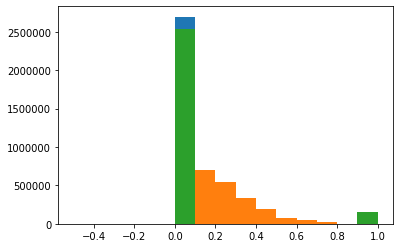

In [685]:
plt.hist(y)
plt.hist(y_pred)
plt.hist(y_pred_binary)
plt.show()

In [25]:
def als_tensor_factorization(student_performance, n_concepts=2, init=3, max_iter=100):
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    # Create student knowledge tensor
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

#     error_run = []
#     error_total_run = []
#     student_performance_pred_run = []
    lambda1 = 0.1
    lambda2 = 0.1
    best_error = 9999
    
    # Several starts
    for run in range(init):
        print("Run: %d" % run)
        error = []
        student_performance_pred_list = []
    #     q_matrix = np.random.rand(N_QUESTIONS, N_CONCEPTS)

        for attempt in range(n_attempts):
            student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)

        # Phase 1: prediction
        student_performance_pred = np.zeros(student_performance.shape)
        for i in range(max_iter):

            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed)
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix <= 0] = 0.0001
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            if not (np.any(q_matrix.sum(axis=0))):
                raise RuntimeError("Q Matrix with empty row")
            q_matrix = q_matrix / row_sums
            
            
            # Update T: T = YQ'(QQ')^(-1) = YQ^(-1)
            # (QQ')^(-1)
#             try:
            q_matrix_transpose_inv = np.linalg.pinv(np.dot(q_matrix, q_matrix.T))
#             except np.linalg.LinAlgError:
#                 continue
            
            # YQ'
            YQ = np.zeros((n_students, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                YQ[:, :, attempt] = np.dot(student_performance[:, :, attempt], q_matrix.T)
                
            # T = YQ'(QQ')^(-1)
            for attempt in range(n_attempts):
                student_knowledge[:, :, attempt] = np.dot(YQ[:, :, attempt], q_matrix_transpose_inv)
                
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error = np.sqrt(np.sum(np.power(diff, 2)))
#             error.append(np.sqrt(np.sum(np.power(diff, 2))))
            if error < best_error:
                best_student_performance_pred = student_performance_pred.copy()
                best_student_knowledge = student_knowledge.copy()
                best_q_matrix = q_matrix.copy()
                best_error = error
            
#             student_performance_pred_iter = student_performance_pred.copy()
#             student_performance_pred_list.append(student_performance_pred_iter)
#         student_performance_pred_run.append(student_performance_pred_list)
#         error_run.append(error)
#         error_total_run.append(error[-1])
    
            
#     return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run
    if best_error == 9999:
        raise RuntimeError("Could not converge")
    return best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error
#     return (np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run, 
#             best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error)

In [26]:
def feedback_driven_tensor_factorization(student_performance, n_concepts=2, mu=0.1, init=3, max_iter=100):
    """ Student performance: 0 if incorrect, 1 if correct or None if not observed """
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    # Construct tensor X denoting when a student has or has not chosen to work on a problem
    X = np.ones(student_performance.shape)
    X[np.where(np.isnan(student_performance))] = 0
    # Complete student knowledge tensor with zero where is NaN
    student_performance[np.where(np.isnan(student_performance))] = 0
    
    # Create student knowledge tensor
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

#     error_run = []
#     error_total_run = []
#     student_performance_pred_run = []
    best_error = 9999
    lambda1 = 0.0001
    
    # Several starts
    for run in range(init):
        print("Run: %d" % run)
#         error = []
        student_performance_pred_list = []

#         for attempt in range(n_attempts):
#             student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)
        q_matrix = np.random.rand(n_concepts, n_questions)
         # Impose non-negativity constraint
        q_matrix[q_matrix <= 0] = 0.0001
        # Normalize rows to sum one
        row_sums = q_matrix.sum(axis=0, keepdims=True)
        if not (np.any(q_matrix.sum(axis=0))):
            raise RuntimeError("Q Matrix with empty row")
        q_matrix = q_matrix / row_sums

        student_performance_pred = np.zeros(student_performance.shape)
        for i in range(max_iter):
            # Phase 2: learning
            # Update T: T = 2*(T_{t-1}) + 2*((1-T_{t-1})/(1+exp(-mu*X_{t}*Q'))) - 1
            # For T0 user T-1 as 0
            student_knowledge[:, :, 0] = (2/(1+np.exp(-mu*np.dot(X[:,:,0], q_matrix.T))))-1
            for attempt in range(1, n_attempts):
                student_knowledge[:, :, attempt] = (2*student_knowledge[:, :, attempt-1]) + \
                2*(1-student_knowledge[:, :, attempt-1])/(1+np.exp(-mu*np.dot(X[:,:,attempt], q_matrix.T))) - 1
                
            # Phase 1: prediction
            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
                
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
#             try:
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed+lambda1)
#             except np.linalg.LinAlgError:
#                 return student_knowledge, X, q_matrix, student_knowledge_transposed_inv, TY
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix <= 0] = 0.0001
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            if not (np.all(row_sums)):
                raise RuntimeError("Q Matrix with empty row")
#                 print("Q Matrix with empty row")
#                 return q_matrix
            q_matrix = q_matrix / row_sums
            
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error = np.sqrt(np.sum(np.power(diff, 2)))
#             error.append(np.sqrt(np.sum(np.power(diff, 2))))
            if error < best_error:
                best_student_performance_pred = student_performance_pred.copy()
                best_student_knowledge = student_knowledge.copy()
                best_q_matrix = q_matrix.copy()
                best_error = error
            
#             student_performance_pred_iter = student_performance_pred.copy()
#             student_performance_pred_list.append(student_performance_pred_iter)
#         student_performance_pred_run.append(student_performance_pred_list)
#         error_run.append(error)
#         error_total_run.append(error[-1])
                
#     return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run
    if best_error == 9999:
        raise RuntimeError("Could not converge")
    return best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error
#     return (np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run, 
#             best_student_performance_pred, best_student_knowledge, best_q_matrix, best_error)